In [1]:
import sqlite3
import csv
from utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
database_path="census.db"
#As we are visualizing from married and unmarried perspective we
#removed relationship as it was not making sense for eg. there is nothing like unmarried husband or married child
all_a=['workclass','education','education_num','occupation','race','sex','native_country','income']
all_m=['age','fnlwgt','capital_gain','capital_loss','hours_per_week']
all_f=['avg','max','min','sum','count']

top_k=5
num_of_partitions=5
delta=0.01
con = sqlite3.connect(database_path)


In [3]:
def create_main_database():
    cur=con.cursor()
    cur.execute("DROP TABLE IF EXISTS census")
    cur.execute("CREATE TABLE IF NOT EXISTS census(age INTEGER,workclass VARCHAR(200) NULL,fnlwgt INTEGER,education VARCHAR(200),education_num INTEGER,marital_status VARCHAR(200),occupation VARCHAR(200) NULL, relationship VARCHAR(200),race VARCHAR(200),sex VARCHAR(200),capital_gain INTEGER,capital_loss INTEGER,hours_per_week INTEGER,native_country VARCHAR(200) NULL,income VARCHAR(200))")
    with open("census+income/adult.data", "r") as file:
        contents = csv.reader(file)
        attribute_tupple=('age','workclass','fnlwgt','education','education_num','marital_status','occupation', 'relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country','income')
        _placeholder=place_holder(attribute_tupple)
        insert_records = f"INSERT INTO census VALUES {_placeholder}"
        cur.executemany(insert_records, contents)
    con.commit()
    print("Created Main Database")

def create_married_unmarried_database():
    cur = con.cursor()
    cur.execute("DROP TABLE IF EXISTS married")
    cur.execute("DROP TABLE IF EXISTS unmarried")

    # Create table for married individuals
    cur.execute("CREATE TABLE married AS SELECT * FROM census WHERE TRIM(marital_status) IN ('Married-spouse-absent', 'Married-civ-spouse', 'Separated', 'Widowed', 'Married-AF-spouse')")
    cur.execute("ALTER TABLE married DROP COLUMN marital_status")
    # Create table for unmarried individuals
    cur.execute("CREATE TABLE unmarried AS SELECT * FROM census WHERE TRIM(marital_status) IN ('Divorced', 'Never-married')")
    cur.execute("ALTER TABLE unmarried DROP COLUMN marital_status")
    con.commit()
    print("Created Married and Unmarried Database")

In [4]:
create_main_database()

Created Main Database


In [5]:
create_married_unmarried_database()

Created Married and Unmarried Database


In [6]:
def find_target_table_and_ref_table(target_table,reference_table,a_column,f_m_column,aggregate):
  # collecting all the data one by one in a row in a single dictionary
  # for preparing probability distribution from target table and reference table
  final_dict={}
  for row in range(len(target_table)):
    if target_table[f_m_column][row]!=0:
      if target_table[a_column][row] not in final_dict:
        final_dict[target_table[a_column][row]]=[[target_table[f_m_column][row]]]
      else:
        final_dict[target_table[a_column][row]][0].append(target_table[f_m_column][row])
    #added 1e-9 as it will show error for attribute value 0 during kl divergence calculation
    else:
      if target_table[a_column][row] not in final_dict:
        final_dict[target_table[a_column][row]]=[[1e-9]]
      else:
        final_dict[target_table[a_column][row]][0].append(1e-9)
  for row in range(len(reference_table)):
    #if the attribute value on in the target table
    if reference_table[a_column][row] not in final_dict:
      final_dict[reference_table[a_column][row]]=[[1e-9]]
    if reference_table[f_m_column][row]!=0:
      if len(final_dict[reference_table[a_column][row]])!=2:
        final_dict[reference_table[a_column][row]].append([reference_table[f_m_column][row]])
      else:
        final_dict[reference_table[a_column][row]][1].append(reference_table[f_m_column][row])
    else:
      if len(final_dict[reference_table[a_column][row]])!=2:
        final_dict[reference_table[a_column][row]].append([1e-9])
      else:
        final_dict[reference_table[a_column][row]][1].append(1e-9)

  #if the attribute value is in target table but not in reference table
  for key,value in final_dict.items():
    if len(value)!=2:
      final_dict[key].append([1e-9])

  final_dict=get_updated_table_based_on_aggregate_group_by(final_dict,aggregate)

  target_list=[]
  reference_list=[]
  for i in final_dict.values():
    target_list.append(i[0])
    reference_list.append(i[1])
  return target_list,reference_list


def get_updated_table_based_on_aggregate_group_by(final_dict,aggregate):
  # manual calculation on aggregate for combine multiple group-by method as sqlite does not have grouping sets feature
  if aggregate=='avg':
    for key,value in final_dict.items():
      tar_mean_val=np.mean(value[0])
      ref_mean_val=np.mean(value[1])
      final_dict[key][0]=tar_mean_val
      final_dict[key][1]=ref_mean_val
  elif aggregate=='sum':
    for key,value in final_dict.items():
      tar_mean_val=np.sum(value[0])
      ref_mean_val=np.sum(value[1])
      final_dict[key][0]=tar_mean_val
      final_dict[key][1]=ref_mean_val
  elif aggregate=='max':
    for key,value in final_dict.items():
      tar_mean_val=np.max(value[0])
      ref_mean_val=np.max(value[1])
      final_dict[key][0]=tar_mean_val
      final_dict[key][1]=ref_mean_val
  elif aggregate=='min':
    for key,value in final_dict.items():
      tar_mean_val=np.min(value[0])
      ref_mean_val=np.min(value[1])
      final_dict[key][0]=tar_mean_val
      final_dict[key][1]=ref_mean_val
  elif aggregate=='count':
    for key,value in final_dict.items():
      tar_mean_val=len(value[0])
      ref_mean_val=len(value[1])
      final_dict[key][0]=tar_mean_val
      final_dict[key][1]=ref_mean_val
  return final_dict

### Normal All Views Execution

In [7]:
#iterating over all the views
start_time=time.time()
final_ans={}
for a in all_a:
  for f in all_f:
    for m in all_m:
      married_query=f'select {a},{f}({m}) from married where {a} is not " ?" group by {a}'
      unmarried_query=f'select {a},{f}({m}) from unmarried where {a} is not " ?" group by {a}'
      cur = con.cursor()
      married_result=cur.execute(married_query)
      target_table=pd.DataFrame(married_result.fetchall())
      cur = con.cursor()
      unmarried_result=cur.execute(unmarried_query)
      reference_table=pd.DataFrame(unmarried_result.fetchall())
      target_list,reference_list=find_target_table_and_ref_table(target_table,reference_table,0,1,'avg')
      final_ans[a,f,m]=kl_divergence(target_list,reference_list)
result_list = sorted(final_ans.items(), key=lambda item: item[1],reverse=True)
end_time=time.time()
print(end_time-start_time)
print(result_list)
print(result_list[:top_k])

9.228094339370728
[(('native_country', 'min', 'capital_loss'), 24.01496317704784), (('native_country', 'avg', 'capital_loss'), 14.786019167819829), (('native_country', 'max', 'capital_loss'), 12.332418170225857), (('occupation', 'avg', 'capital_loss'), 8.519342852295644), (('native_country', 'avg', 'capital_gain'), 6.972511020461741), (('native_country', 'max', 'capital_gain'), 4.6586879384136015), (('education_num', 'max', 'capital_loss'), 2.7298424461501978), (('education', 'max', 'capital_loss'), 2.7298424461501973), (('education', 'avg', 'capital_loss'), 2.499400420923598), (('education_num', 'avg', 'capital_loss'), 2.499400420923598), (('education', 'max', 'capital_gain'), 1.535674470226553), (('education_num', 'max', 'capital_gain'), 1.535674470226553), (('education_num', 'avg', 'capital_gain'), 1.4979782421587824), (('education', 'avg', 'capital_gain'), 1.4979782421587822), (('occupation', 'max', 'capital_loss'), 1.3912033720458974), (('native_country', 'sum', 'capital_loss'), 0

## Share Based Optimization (Combine Multiple Aggregate)

In [8]:
def combine_multiple_aggregate(a,f_m):
    #combining multiple aggregates
    group_by=" group by "+f"{a}"
    from_married=" from married"
    from_unmarried=" from unmarried"
    where= f' where {a} is not " ?" '
    query="select "+f"{a}"+ f_m
    married_query=query+from_married+where+group_by
    unmarried_query=query+from_unmarried+where+group_by
    return married_query,unmarried_query


In [9]:
start_time=time.time()
f_m=" "
fm_list=[]
for f in all_f:
  for m in all_m:
    f_m=f_m+f",{f}({m})"
    fm_list.append((f,m))
final_ans={}
for a in all_a:
  married_query,unmarried_query=combine_multiple_aggregate(a,f_m)
  cur = con.cursor()
  married_result=cur.execute(married_query)
  target_table=pd.DataFrame(married_result.fetchall())

  cur.close()
  cur = con.cursor()
  unmarried_result=cur.execute(unmarried_query)
  reference_table=pd.DataFrame(unmarried_result.fetchall())
  for f_m_column in range(1,len(fm_list)+1):
    target_list,reference_list=find_target_table_and_ref_table(target_table,reference_table,0,f_m_column,fm_list[f_m_column-1][0])
    final_ans[(a,fm_list[f_m_column-1][0],fm_list[f_m_column-1][1])]=kl_divergence(target_list,reference_list)
result_list = sorted(final_ans.items(), key=lambda item: item[1],reverse=True)
end_time=time.time()
print(end_time-start_time)
print(result_list[:top_k])
print(result_list)

1.743326187133789
[(('native_country', 'min', 'capital_loss'), 24.01496317704784), (('native_country', 'avg', 'capital_loss'), 14.786019167819829), (('native_country', 'max', 'capital_loss'), 12.332418170225857), (('occupation', 'avg', 'capital_loss'), 8.519342852295644), (('native_country', 'avg', 'capital_gain'), 6.972511020461741)]
[(('native_country', 'min', 'capital_loss'), 24.01496317704784), (('native_country', 'avg', 'capital_loss'), 14.786019167819829), (('native_country', 'max', 'capital_loss'), 12.332418170225857), (('occupation', 'avg', 'capital_loss'), 8.519342852295644), (('native_country', 'avg', 'capital_gain'), 6.972511020461741), (('native_country', 'max', 'capital_gain'), 4.6586879384136015), (('education_num', 'max', 'capital_loss'), 2.7298424461501978), (('education', 'max', 'capital_loss'), 2.7298424461501973), (('education', 'avg', 'capital_loss'), 2.499400420923598), (('education_num', 'avg', 'capital_loss'), 2.499400420923598), (('education', 'max', 'capital_ga

## Share Based Optimization (Combine Multiple Aggregate) (Combine Reference Query and Target Query)

In [10]:
def combine_multiple_aggregate_and_queries(a,f_m):
  #combining multiple aggregates and target and reference queries
  group_by=" group by "+f"{a}"
  from_census=" from census"
  where= f' where {a} is not " ?" '
  case_clause=", CASE WHEN TRIM(marital_status) IN ('Married-spouse-absent', 'Married-civ-spouse', 'Separated', 'Widowed', 'Married-AF-spouse') THEN 1 ELSE 0 END as g1, CASE WHEN TRIM(marital_status) IN ('Divorced', 'Never-married') THEN 1 ELSE 0 END as g2"
  combined_query="select "+f"{a}"+f_m+case_clause+from_census+where+group_by+",g1,g2"
  return combined_query


In [11]:
start_time=time.time()
f_m=" "
fm_list=[]
for f in all_f:
  for m in all_m:
    f_m=f_m+f",{f}({m})"
    fm_list.append((f,m))
final_ans={}
for a in all_a:
  combined_query=combine_multiple_aggregate_and_queries(a,f_m)
  cur = con.cursor()
  married_unmarried_result=cur.execute(combined_query)

  all_table=pd.DataFrame(married_unmarried_result.fetchall())
  cur.close()
  target_table=all_table.where(all_table[26]==1).dropna().reset_index()
  reference_table=all_table.where(all_table[27]==1).dropna().reset_index()
  for f_m_column in range(1,len(fm_list)+1):
    target_list,reference_list=find_target_table_and_ref_table(target_table,reference_table,0,f_m_column,fm_list[f_m_column-1][0])
    final_ans[(a,fm_list[f_m_column-1][0],fm_list[f_m_column-1][1])]=kl_divergence(target_list,reference_list)
result_list = sorted(final_ans.items(), key=lambda item: item[1],reverse=True)
end_time=time.time()
print(end_time-start_time)
print(result_list[:top_k])

1.386073112487793
[(('native_country', 'min', 'capital_loss'), 24.01496317704784), (('native_country', 'avg', 'capital_loss'), 14.786019167819829), (('native_country', 'max', 'capital_loss'), 12.332418170225857), (('occupation', 'avg', 'capital_loss'), 8.519342852295644), (('native_country', 'avg', 'capital_gain'), 6.972511020461741)]


## Share Based Optimization (Combine Multiple Aggregate and Group By)

In [12]:
def combine_multiple_aggregate_and_groupby():
  #combining multiple aggregates and group by
    f_m=" "
    fm_list=[]
    for f in all_f:
        for m in all_m:
            f_m=f_m+f",{f}({m})"
            fm_list.append((f,m))

    select="select"
    group_by=" group by"
    where=" where "
    for a in all_a:
        select=select+f" {a},"
        group_by=group_by+f" {a},"
        where= f' where {a} is not " ?" and '
    select=select[:-1]
    group_by=group_by[:-1]
    where=where[:-4]

    from_married=" from married"
    from_unmarried=" from unmarried"
    married_query=select+f_m+from_married+where+group_by
    unmarried_query=select+f_m+from_unmarried+where+group_by
    return married_query,unmarried_query,fm_list


In [13]:
start_time=time.time()
married_query,unmarried_query,fm_list=combine_multiple_aggregate_and_groupby()
cur = con.cursor()
married_result=cur.execute(married_query)
target_table=pd.DataFrame(married_result.fetchall())
cur.close()
cur = con.cursor()
unmarried_result=cur.execute(unmarried_query)
reference_table=pd.DataFrame(unmarried_result.fetchall())
cur.close()
final_ans={}
for a_column in range(len(all_a)):
    for f_m_column in range(len(all_a),len(all_a)+len(fm_list)):
        target_list,reference_list=find_target_table_and_ref_table(target_table,reference_table,a_column,f_m_column,fm_list[f_m_column-len(all_a)][0])
        final_ans[(all_a[a_column],fm_list[f_m_column-len(all_a)][0],fm_list[f_m_column-len(all_a)][1])]=kl_divergence(target_list,reference_list)
result_list = sorted(final_ans.items(), key=lambda item: item[1],reverse=True)
end_time=time.time()
print(end_time-start_time)
print(result_list[:top_k])

33.63612914085388
[(('native_country', 'min', 'capital_loss'), 24.007370705971454), (('native_country', 'avg', 'capital_loss'), 14.303323026145657), (('native_country', 'max', 'capital_loss'), 11.8960221527327), (('occupation', 'avg', 'capital_loss'), 8.416759833686148), (('native_country', 'avg', 'capital_gain'), 6.478983727628643)]


## Share Based Optimization (Combine Multiple Aggregate and Group By) (Combine Reference Query and Target Query)

In [14]:
def combine_multiple_aggregate_and_groupby_and_queries():
  #combining multiple aggregates and group by and queries
  f_m=" "
  fm_list=[]
  for f in all_f:
      for m in all_m:
          f_m=f_m+f",{f}({m})"
          fm_list.append((f,m))

  select="select"
  group_by=" group by"
  where=" where "
  for a in all_a:
      select=select+f" {a},"
      group_by=group_by+f" {a},"
      where= f' where {a} is not " ?" and '
  select=select[:-1]
  group_by=group_by[:-1]
  where=where[:-4]
  from_census=" from census"
  case_clause=", CASE WHEN TRIM(marital_status) IN ('Married-spouse-absent', 'Married-civ-spouse', 'Separated', 'Widowed', 'Married-AF-spouse') THEN 1 ELSE 0 END as g1, CASE WHEN TRIM(marital_status) IN ('Divorced', 'Never-married') THEN 1 ELSE 0 END as g2"
  combined_query=select+f_m+case_clause+from_census+where+group_by+",g1,g2"
  return combined_query,fm_list


In [15]:
start_time=time.time()
combined_query,fm_list=combine_multiple_aggregate_and_groupby_and_queries()
cur = con.cursor()
married_unmarried_result=cur.execute(combined_query)
all_table=pd.DataFrame(married_unmarried_result.fetchall())
cur.close()
target_table=all_table.where(all_table[33]==1).dropna().reset_index()
reference_table=all_table.where(all_table[34]==1).dropna().reset_index()
final_ans={}
for a_column in range(len(all_a)):
    for f_m_column in range(len(all_a),len(all_a)+len(fm_list)):
        target_list,reference_list=find_target_table_and_ref_table(target_table,reference_table,a_column,f_m_column,fm_list[f_m_column-len(all_a)][0])
        final_ans[(all_a[a_column],fm_list[f_m_column-len(all_a)][0],fm_list[f_m_column-len(all_a)][1])]=kl_divergence(target_list,reference_list)
result_list = sorted(final_ans.items(), key=lambda item: item[1],reverse=True)
end_time=time.time()
print(end_time-start_time)
print(result_list[:top_k])

31.22921848297119
[(('native_country', 'min', 'capital_loss'), 24.007370705971454), (('native_country', 'avg', 'capital_loss'), 14.303323026145657), (('native_country', 'max', 'capital_loss'), 11.8960221527327), (('occupation', 'avg', 'capital_loss'), 8.416759833686148), (('native_country', 'avg', 'capital_gain'), 6.478983727628643)]


## Pruning Based Method (Interval Based Method)

In [16]:
def find_mean_and_bound(res_dict,num_of_partitions,delta):
    #finding confidence interval and upper bound and lower bound
    stats_dict={}
    for key,values in res_dict.items():
        mean=np.mean(values)
        #here I have done len(values)+1 as I did not want log(log(1)) to throw any error
        ci=confidence_interval(len(values)+1,num_of_partitions,delta)
        upper_bound=mean+ci
        lower_bound=mean-ci
        stats_dict[key]=(mean,upper_bound,lower_bound)
    return stats_dict

In [17]:
start_time=time.time()
# married_query,unmarried_query,fm_list=combine_multiple_aggregate_and_groupby()
# cur = con.cursor()
# married_result=cur.execute(married_query)
# target_table=pd.DataFrame(married_result.fetchall())
# cur.close()
# cur = con.cursor()
# unmarried_result=cur.execute(unmarried_query)
# reference_table=pd.DataFrame(unmarried_result.fetchall())
# cur.close()

combined_query,fm_list=combine_multiple_aggregate_and_groupby_and_queries()
cur = con.cursor()
married_unmarried_result=cur.execute(combined_query)
all_table=pd.DataFrame(married_unmarried_result.fetchall())
cur.close()

target_table=all_table.where(all_table[33]==1).dropna().reset_index()
reference_table=all_table.where(all_table[34]==1).dropna().reset_index()

target_table_partitions=np.array_split(target_table,num_of_partitions)
target_table_partitions=reset_index(target_table_partitions)
reference_table_partitions=np.array_split(reference_table,num_of_partitions)
reference_table_partitions=reset_index(reference_table_partitions)
res_dict={}
removed_views=[]
for i in range(num_of_partitions):
  print(i)
  for a_column in range(len(all_a)):
    for f_m_column in range(len(all_a),len(all_a)+len(fm_list)):
      view_key=(all_a[a_column],fm_list[f_m_column-len(all_a)][0],fm_list[f_m_column-len(all_a)][1])
      if removed_views:
        if view_key in removed_views:
            # go to next iteration
            continue
      target_list,reference_list=find_target_table_and_ref_table(target_table_partitions[i],reference_table_partitions[i],a_column,f_m_column,fm_list[f_m_column-len(all_a)][0])

      if view_key in res_dict:
        res_dict[view_key].append(kl_divergence(target_list,reference_list))
      else:
        res_dict[view_key]=[kl_divergence(target_list,reference_list)]
  stats_dict=find_mean_and_bound(res_dict,num_of_partitions,delta)
  lower_bound=[]

  for view,m_u_l_bound in stats_dict.items():
    lower_bound.append(m_u_l_bound[2])
  sorted_lower_bound=sorted(lower_bound,reverse=True)
  k_lower_bound=sorted_lower_bound[top_k-1]
  views_to_remove = []
  for view,m_u_l_bound in stats_dict.items():
    if m_u_l_bound[1]<k_lower_bound:
      removed_views.append(view)
      views_to_remove.append(view)
  for view in views_to_remove:
    del stats_dict[view]
    del res_dict[view]

final_ans={}
for key,values in res_dict.items():
  final_ans[key]=np.mean(values)
final_ans = list(sorted(final_ans.items(), key=lambda item: item[1],reverse=True))
end_time=time.time()
print(end_time-start_time)
print(final_ans)

0
1
2
3
4
8.11162781715393
[(('native_country', 'avg', 'capital_loss'), 20.98269847041292), (('native_country', 'avg', 'capital_gain'), 18.29712638691184), (('native_country', 'max', 'capital_loss'), 17.554913436842373), (('native_country', 'max', 'capital_gain'), 11.054671326317195), (('native_country', 'min', 'fnlwgt'), 4.918556265951386)]


## Visualization


In [18]:
select="select "
group_by=" group by "
from_married=" from married"
from_unmarried=" from unmarried"


def visualization(a, m, f, con):
    target_query = f"SELECT {a}, {f}({m}) FROM married GROUP BY {a};"
    reference_query = f"SELECT {a}, {f}({m}) FROM unmarried GROUP BY {a};"

    cursor1 = con.cursor()
    cursor2 = con.cursor()
    cursor1.execute(target_query)
    cursor2.execute(reference_query)

    df_married = pd.DataFrame(cursor1.fetchall(), columns=['Category', 'Value'])
    df_unmarried = pd.DataFrame(cursor2.fetchall(), columns=['Category', 'Value'])

    merged_df = pd.merge(df_married, df_unmarried, how='outer', on='Category', suffixes=['_Married', '_Unmarried'])
    merged_df.fillna(0, inplace=True)


    plot_data = {
        'Married': list(merged_df['Value_Married'].astype(float)),
        'Unmarried': list(merged_df['Value_Unmarried'].astype(float))
    }
    df_bar = pd.DataFrame(plot_data, index=list(merged_df['Category']))

    ax = df_bar.plot.bar(xlabel=a, ylabel=f'{f}({m})', rot=90, figsize=(8, 5), color= {
      "#c27ba0",
      "#93c47d",
      "#8e7cc3",
      "#ffd966",
    }, edgecolor='black')
    return ax

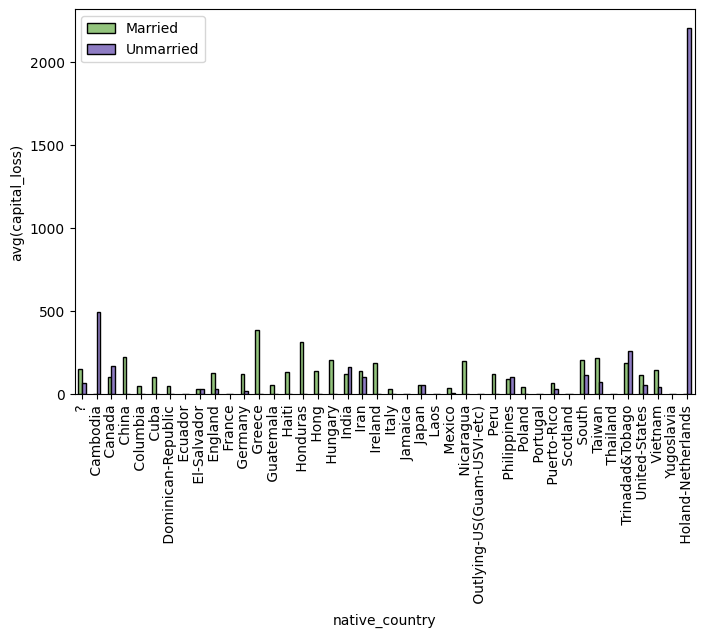

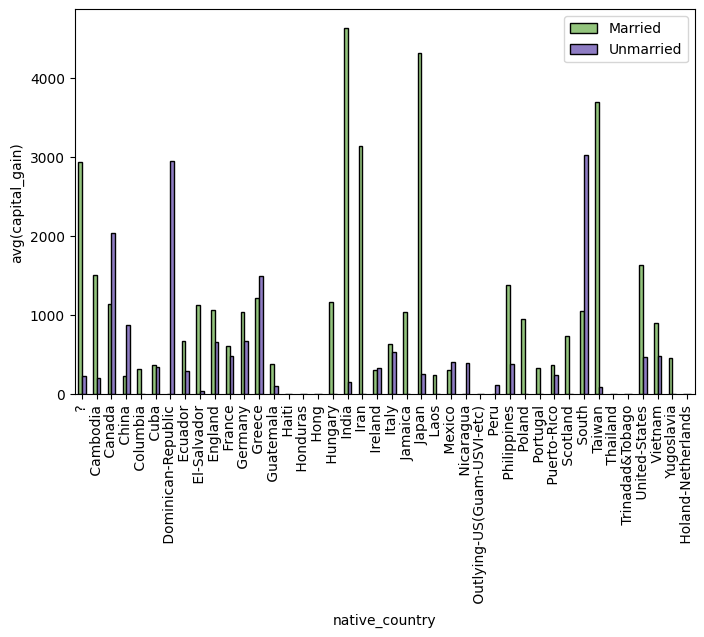

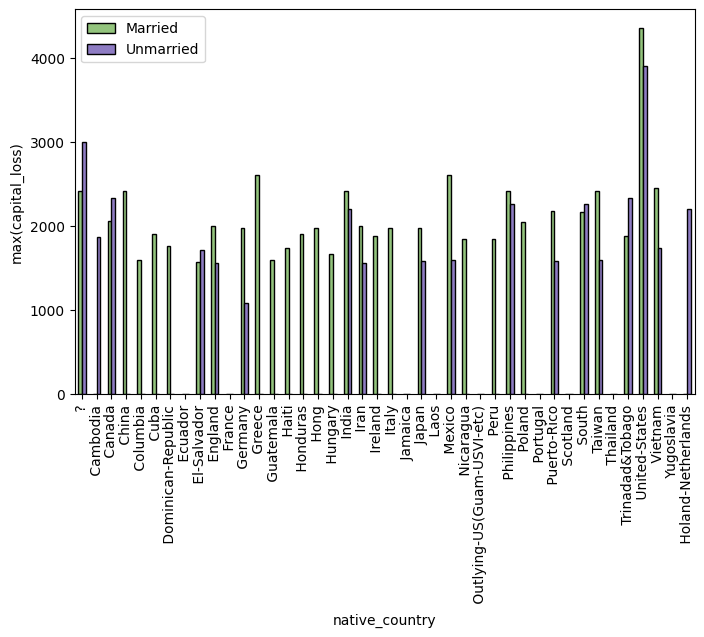

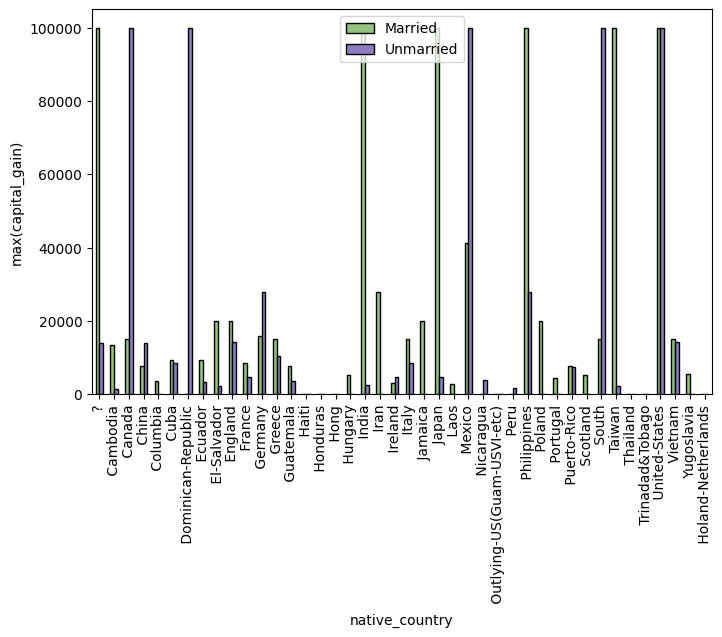

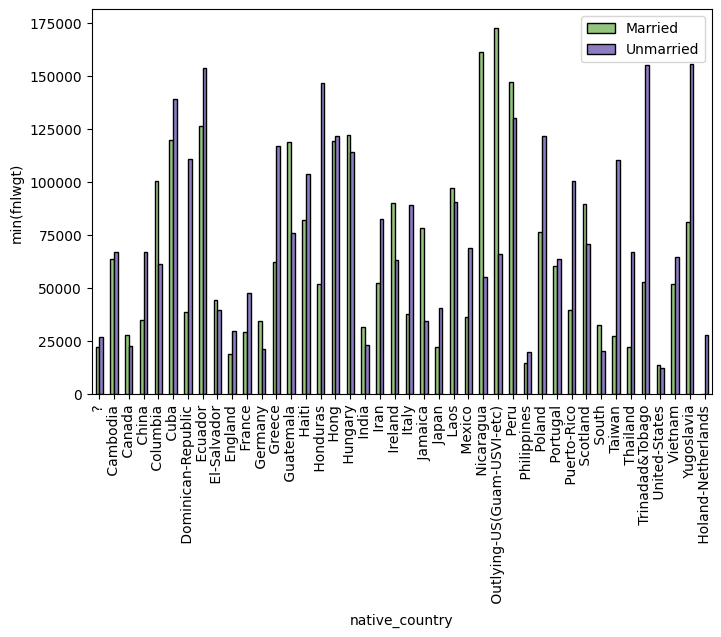

In [19]:
#other methods
#final_ans=[(('native_country', 'min', 'capital_loss'), 24.01496317704784), (('native_country', 'avg', 'capital_loss'), 14.786019167819829), (('native_country', 'max', 'capital_loss'), 12.332418170225857), (('occupation', 'avg', 'capital_loss'), 8.519342852295644), (('native_country', 'avg', 'capital_gain'), 6.972511020461741)]
#pruning based methods
#final_ans=[(('native_country', 'avg', 'capital_loss'), 20.98269847041292), (('native_country', 'avg', 'capital_gain'), 18.29712638691184), (('native_country', 'max', 'capital_loss'), 17.554913436842373), (('native_country', 'max', 'capital_gain'), 11.054671326317195), (('native_country', 'min', 'fnlwgt'), 4.918556265951386)]
for row in final_ans:
    visualization(row[0][0], row[0][2], row[0][1], con)
    plt.savefig(f"PruningImagePDF_{row}.pdf", format="pdf", bbox_inches="tight")